# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

# Inngangur:

## Markmið

Ég bý í Ásahverfinu í Garðabænum, og þarf því oft að taka Strætó 23 á milli húsa foreldra minna, sem hafa skilið. Við þá upplifun er þó ekki hægt að komast hjá því að taka eftir líkindum strætóleiðarinnar við rússíbana – skemmtitækið sem hafði því miður alveg vantað á Íslandi fyrr en Strætó byrjaði að keyra í gegn um hverfið. Sú var ekki eina uppgvötunin sem ég gerði á þessum tíma, en ég komst einnig að því að API Strætóappsins er hægt að nálgast (meira um það fyrir neðan). Augljós samblanda er því að nota API-ið til sýna fram á tölulega hversu hratt þessi strætóleið ekur.

## Tækni

Hér verður farið yfir í stuttu máli þá tækni sem notuð er.

### Open Street Map

Flestir þekkja eflaust Open Street Map, en eins og nafnið gefur til kynna er það götukort sem gefið út er með frjálsu höfundarréttaleyfi. Notkun mín á OSM í þessu verkefni má skipta í tvo hluta.

1. Notkun vektorupplýsinga gatnanna til að búa til falleg kortarit líkt og það sem má sjá hér fyrir neðan.
2. Notkun hámarkshraðagagna gatna sem finna má í upplýsingum hvers götuvektors.

Það vill svo heppilega til að þýska fyrirtækið _Geofabrik_ bíður upp á ókeypis niðurhal OSM gagna einstakra heimshluta, þar á meðal Ísland. Sjá: <https://download.geofabrik.de/europe/iceland.html>

Ég bjó til einfalt fall sem niðurhalar þessum gögnum sjálfkrafa, og kallar í bash forrit sem breytir gögnunum í það form sem við viljum vinna með, og spýtir út í möppuna `osm-data/`, ásamt því búa til Postgresql gagnagrunn að nafni `straeto` sem geymir þessi gögn.

In [1]:
from straeto.data import get_osm_data
get_osm_data(verbose=True)

gis_osm_roads_free_1.cpg extracted to osm-data/
gis_osm_roads_free_1.dbf extracted to osm-data/
gis_osm_roads_free_1.prj extracted to osm-data/
gis_osm_roads_free_1.shp extracted to osm-data/
gis_osm_roads_free_1.shx extracted to osm-data/
Running extract_roads bash script...
Success


Hér má sjá innihald `osm-data/`. Takið eftir að notast er við forskeytið `!` til að keyra bash skipun í stað Python kóða.

In [2]:
!printf 'osm-data/:\n' \
&& ls osm-data/ \
&& printf '\nosm-data/output/:\n' \
&& ls osm-data/output

osm-data/:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output/:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


Hér að lokum má sjá dæmi um vektorupplýsingarnar birtar á kortariti. Vegirnir merktir með svörtu hafa hámarkshraðaupplýsingar, en þeir sem merktir eru með rauðu hafa þær ekki. Ég hef þó passað upp á það að allar strætóleiðirnar hafi hámarkshraðaupplýsingar.

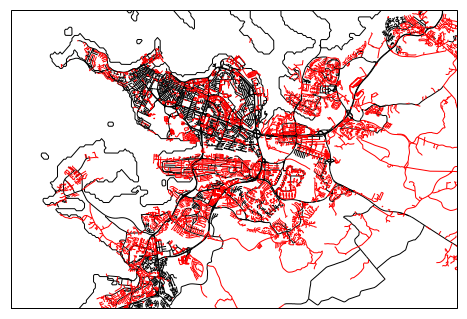

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from straeto import straeto
fig, ax = straeto.get_map(region='reykjavik', res='f')

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

In [ ]:
fig, ax = straeto.get_map(region=[[[-21.925687, -21.957609, 64.082863, 64.095775], 1]], res='f')

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp')
ax = straeto.plot_homes_and_stops(ax)

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [ ]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

In [ ]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann. Það er því aðeins ein leið til að finna út þann fasta k sem uppfyllir jöfnuna fyrir neðan.

$k\cdot v_{api} = v_{real}$

Það er að skoða mörg tilvik af hröðunum v, einangra og útreikna k, og taka svo meðaltal allra k-a.

$k = \frac{v_{real}}{v_{api}}$

In [9]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

In [10]:
from geopy.distance import geodesic
from datetime import datetime as dt

Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)

k = sum(Ks)/len(Ks)
print(k)

1.8767839246460092


### Postgresql + PostGis

Postgresql er gagnagrunnsforritið sem ég mun hér nota, en geri ég það fyrir viðbótina PostGis. PostGis hjálpar forriturum að leysa vandamál sem tengjast geografískum fyrirbærum og tengingunum á milli þeirra.

Búum til stutthöndina `sql` til að framkalla sql skipanir.

In [ ]:
%alias sql psql straeto -c

## Gögn

Ég skrifaði Python forrit sem rann á tölvunni minni í 64 daga talsins, og vistaði gögnin úr Strætó API-inu í sql skjöl, eitt fyrir hvern dag. Þau má nálgast í `straeto-data/` möppunni. Forrit þetta má einnig hér nálgast, en er það ekki mjög vandað og mæli ég með því að skrifa ykkar eigið.

# Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
Started 22:37
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

## Sameining gagna

In [ ]:
!pgloader straeto-data/25-03-2018.db postgresql:///straeto \
&& pgloader straeto-data/06-07-2018.db postgresql:///straeto

Skoðum uppbyggingu gagnagrunnsins, en hann er byggður upp af tveimur töflum:

In [ ]:
sql "\dt"

1. Fyrst er það `buses` en hún geymir upplýsingarnar frá strætó API-inu.
2. Svo er það `roads`, sem geymir gögnin frá Open Street Map, þar á meðal hámarkshraðagögn

## Undirbúningur

Nokkrar sql skipanir þarf að gera til undirbúnings:

1. Bætir við súlunni `geom` við töfluna `buses` af gerðinni `Geometry(Point, 4326)`. Þessi gerð geimir einfaldlega geografískan punkt, og vísar talan 4326 einfaldlega til jarðarsporvölsins ESPG:4326 (_European Petroleum Survey Group_), betur þekktur sem [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System) (_World Geodetic System_).

In [ ]:
sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

2. Fyllir nýbökuðu súluna með gögnum úr súlunum `lat`, og `lon`.

In [ ]:
sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

3. Býr til svokallaðan _Geospatial Index_, sem flýtir fyrir ýmsum geografískum skipunum PostGis.

In [ ]:
sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

4. Ryksugar gagnagrunninn, en það er nauðsynlegt eftir að hafa búið til _Geospatial Index_.

In [ ]:
sql "VACUUM ANALYZE;"

5. Bætil við súlunni `maxspeed` við töfluna `buses` af gerðinni `integer` (heiltala).

In [ ]:
sql "ALTER TABLE buses ADD maxspeed integer;"

6. Finnur hámarkshraða vegsins sem hver punktur Strætóvagnanna situr á. Þetta er flókin og kostnaðarsöm aðgerð, svo það má búast við því að hafa hana í gangi í minnsta kosti 6 klst fyrir hvern dag (fer eftir hraða tölvunnar þinnar).

In [ ]:
sql "UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r \
WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);"

Í einföldu máli er súlan `maxspeed` í töflunni `buses` sett sem niðurstaða eftirfarandi skipunar:
```sql
SELECT r.maxspeed
FROM roads r
WHERE ST_Expand(b.geom, 0.012) && r.geom
ORDER BY b.geom <-> r.geom
LIMIT 1;
```
Fallið `ST_Expand(POINT, DISTANCE)` skilar hring með radíus `DISTANCE` og miðju `POINT`. Virkjinn `GEOM1 && GEOM2` skilar jákvæðu ef `GEOM1` og `GEOM2` skarast á, og virkjinn `GEOM1 <-> GEOM2` skilar fjarlægðinni á milli `GEOM1` og `GEOM2`.

# Úrvinnsla gagna:

Sækjum gögnin frá Postgresql gagnagrunninum okkar fyrir í Python.

In [6]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

connection = pg.connect(database='straeto',
                        # Location of .s.PGSQL.5432 file;
                        # try host='/tmp' if you get an error.
                        host='/var/run/postgresql')

df = pd_sql.read_sql("SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;", connection)
df['gps_time'] = pd.to_datetime(df['gps_time'], format='%y%m%d%H%M%S')
df = df.set_index('gps_time')

DatabaseError: Execution failed on sql 'SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;': relation "buses" does not exist
LINE 1: ...ps_time, route_number, lat, lon, speed, maxspeed FROM buses;
                                                                 ^


Við höfum aðeins áhuga á þeim tilvikum þar sem hámarkshraðagögn má finna:

In [11]:
df = df.query('maxspeed > 0')

NameError: name 'df' is not defined

Margföldum hraðann með fastanum k sem við fundum áðan til að fá hann í kílómetrum á klukkustund.

In [ ]:
df['speed'] = df['speed']*k

Skilgreinum súluna `ratio` þar sem má finna hlutfall hraða og hámarkshraða.

In [ ]:
df['ratio'] = df['speed']/df['maxspeed']

In [ ]:
%matplotlib inline
import numpy as np

x = df['lon']
y = df['lat']
ratios = df['ratio']

fig, (ax, ax2) = straeto.get_map(region=[['reykjavik', 1.15], 'iceland'], res='f',
                                 figsize=(14, 7), shape=(1, 2))
# The heatmap itself
im = straeto.add_heatmap(ax, x, y, ratios, bins=4000, statistic='median')
im = straeto.add_heatmap(ax2, x, y, ratios, bins=65, statistic='median')
# The colourbar
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Hitakort hlutfalls ekins– og leyfilegs aksturshraða', size=16)
ax.set_title('Höfuðborgarsvæðið')
ax2.set_title('Landsbyggðin')

fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()

In [ ]:
df_23 = df.query('route_number == "23"')
df_23.head(3)

In [ ]:
import shapely.geometry as sgeom

box = sgeom.box(minx=-21.957609, maxx=-21.925687, miny=64.082863, maxy=64.095775)
x0, y0, x1, y1 = box.bounds

x = df_23['lon']
y = df_23['lat']
ratios = df_23['ratio']

fig, (ax, ax2) = straeto.get_map(region=[[[-22.043032, -21.878363, 64.072429, 64.113672], 0.9],
                                 [[x0, x1, y0, y1], 0.9]],
                          res='f', figsize=(14, 7), shape=(1, 2))

ax2 = straeto.add_shapefile(ax2, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax2 = straeto.add_shapefile(ax2, 'osm-data/output/no_extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp')

im = straeto.add_heatmap(ax, x, y, ratios, bins=40, statistic='median')
ax.add_geometries([box], ccrs.PlateCarree(), facecolor='yellow', edgecolor='black', alpha=0.5)

im = straeto.add_heatmap(ax2, x, y, ratios, bins=200, statistic='median')
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Strætó 23 á ferð í Ásahverfinu', size=16)
fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()